# Analysis using Linear Regression (Ridge)

In [1]:
import pandas

In [2]:
dataset = pandas.read_csv("../data/stopoutput123.csv")
dataset.head()

dataset = dataset.head(500_000)

/var/folders/0d/y9xg9gkj7y1ffmn0_g8_k68w0000gn/T/ipykernel_35799/2456314002.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pandas.read_csv("../data/stopoutput123.csv")


In [3]:
actual_time = pandas.to_datetime(dataset['timestamp'].str.split(' ').str[0] + ' ' + dataset['actualTime'], errors='coerce')
planned_time = pandas.to_datetime(dataset['timestamp'].str.split(' ').str[0] + ' ' + dataset['plannedTime'], errors='coerce')

dataset['delay'] = (actual_time - planned_time).dt.total_seconds() / 60

dataset = dataset[dataset['delay'].abs() < 60]

dataset.head()

,timestamp,busStopID,stopName,patternText,direction,actualTime,plannedTime,status,routeId,tripId,vehicleId,delay
0,2024-12-21 00:00:02,1050,Rungholtplatz,N22,Schwentinental,00:22,00:22,PREDICTED,1610073983892324360,1.610078e+18,-7.638105e+18,0.0
1,2024-12-21 00:00:02,1062,"Wik, Kanal",N11,Dietrichsdorf,00:00,00:00,STOPPING,1610073983892324359,1.610078e+18,-7.638105e+18,0.0
2,2024-12-21 00:00:02,1005,Belvedere,N12,Strande,00:04,00:02,PREDICTED,1610073983892324353,1.610078e+18,-7.638105e+18,2.0
3,2024-12-21 00:00:02,1005,Belvedere,N11,Dietrichsdorf,00:05,00:05,PREDICTED,1610073983892324359,1.610078e+18,-7.638105e+18,0.0
4,2024-12-21 00:00:02,1064,"Schilksee, Kirche",N12,Eiderbrücke,00:10,00:10,PREDICTED,1610073983892324353,1.610078e+18,-7.638105e+18,0.0


In [4]:
import numpy as np

dataset['weekday'] = actual_time.dt.day_name()
dataset['month'] = actual_time.dt.month

# time conversion to sine and cosine
# this is to capture the cyclical nature of time in a way that ml models can learn
seconds_in_day = 24 * 60 * 60
time_in_seconds = actual_time.dt.hour * 3600 + actual_time.dt.minute * 60 + actual_time.dt.second
dataset['time_sin'] = np.sin(2 * np.pi * time_in_seconds / seconds_in_day)
dataset['time_cos'] = np.cos(2 * np.pi * time_in_seconds / seconds_in_day)

dataset.head()

,timestamp,busStopID,stopName,patternText,direction,actualTime,plannedTime,status,routeId,tripId,vehicleId,delay,weekday,month,time_sin,time_cos
0,2024-12-21 00:00:02,1050,Rungholtplatz,N22,Schwentinental,00:22,00:22,PREDICTED,1610073983892324360,1.610078e+18,-7.638105e+18,0.0,Saturday,12.0,0.095846,0.995396
1,2024-12-21 00:00:02,1062,"Wik, Kanal",N11,Dietrichsdorf,00:00,00:00,STOPPING,1610073983892324359,1.610078e+18,-7.638105e+18,0.0,Saturday,12.0,0.000000,1.000000
2,2024-12-21 00:00:02,1005,Belvedere,N12,Strande,00:04,00:02,PREDICTED,1610073983892324353,1.610078e+18,-7.638105e+18,2.0,Saturday,12.0,0.017452,0.999848
3,2024-12-21 00:00:02,1005,Belvedere,N11,Dietrichsdorf,00:05,00:05,PREDICTED,1610073983892324359,1.610078e+18,-7.638105e+18,0.0,Saturday,12.0,0.021815,0.999762
4,2024-12-21 00:00:02,1064,"Schilksee, Kirche",N12,Eiderbrücke,00:10,00:10,PREDICTED,1610073983892324353,1.610078e+18,-7.638105e+18,0.0,Saturday,12.0,0.043619,0.999048


In [5]:
dataset = dataset.drop(columns=["busStopID", "timestamp", "routeId", "actualTime", "plannedTime", "tripId", "vehicleId", "status"])

dataset.head()

,stopName,patternText,direction,delay,weekday,month,time_sin,time_cos
0,Rungholtplatz,N22,Schwentinental,0.0,Saturday,12.0,0.095846,0.995396
1,"Wik, Kanal",N11,Dietrichsdorf,0.0,Saturday,12.0,0.000000,1.000000
2,Belvedere,N12,Strande,2.0,Saturday,12.0,0.017452,0.999848
3,Belvedere,N11,Dietrichsdorf,0.0,Saturday,12.0,0.021815,0.999762
4,"Schilksee, Kirche",N12,Eiderbrücke,0.0,Saturday,12.0,0.043619,0.999048


In [6]:
dataset_ready = pandas.get_dummies(dataset, dummy_na=True)
dataset_ready = dataset_ready.dropna(subset=['delay'])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge  # oder Lasso

import numpy as np

In [8]:
y = dataset_ready["delay"]
X_raw = dataset_ready.drop(columns=["delay"])

from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0)
X = X_raw.loc[:, selector.fit(X_raw).get_support()]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", Ridge(alpha=1.0))
])

In [11]:
pipe.fit(X_train, y_train)


Pipeline(steps=[('imputer', SimpleImputer()),
                ('scaler', StandardScaler(with_mean=False)),
                ('model', Ridge())])

In [12]:
y_pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE : {mae:.2f} Minuten")
print(f"RMSE: {rmse:.2f} Minuten")


MAE : 0.91 Minuten
RMSE: 1.97 Minuten


In [13]:
coeffs = pandas.Series(
    pipe.named_steps["model"].coef_,
    index=X.columns
).sort_values(key=abs, ascending=False)

print(coeffs.head(20))

time_sin                  -0.196163
direction_Strande          0.159825
direction_Elmschenhagen   -0.126847
weekday_Saturday           0.121820
direction_Projensdorf      0.119985
direction_Mettenhof       -0.112270
patternText_62            -0.108652
time_cos                  -0.089657
weekday_Thursday          -0.084818
weekday_Wednesday         -0.084668
weekday_Friday             0.079992
patternText_999            0.076013
direction_XXX              0.076013
patternText_14             0.075332
patternText_8             -0.074654
direction_Russee           0.069761
direction_Wik             -0.069119
patternText_N12           -0.065127
patternText_31             0.064975
patternText_11             0.064389
dtype: float64


In [ ]:
def predict_delay(stop_name, pattern_text, direction, weekday, month, hour, minute):
    valid_stops = set(dataset['stopName'].unique())
    valid_patterns = set(dataset['patternText'].unique())
    valid_directions = set(dataset['direction'].unique())
    valid_weekdays = set(dataset['weekday'].unique())
    
    # fallbacks if inputs are not valid
    original_inputs = (stop_name, pattern_text, direction, weekday)
    
    if stop_name not in valid_stops:
        stop_name = dataset['stopName'].value_counts().index[0]
        print(f"Warning: Stop '{original_inputs[0]}' not found. Using most frequent: '{stop_name}'")
    
    if pattern_text not in valid_patterns:
        pattern_text = dataset['patternText'].value_counts().index[0]
        print(f"Warning: Line '{original_inputs[1]}' not found. Using most frequent: '{pattern_text}'")
    
    if direction not in valid_directions:
        direction = dataset['direction'].value_counts().index[0]
        print(f"Warning: Direction '{original_inputs[2]}' not found. Using most frequent: '{direction}'")
    
    if weekday not in valid_weekdays:
        weekday = dataset['weekday'].value_counts().index[0]
        print(f"Warning: Weekday '{original_inputs[3]}' not found. Using most frequent: '{weekday}'")
    
    sample = {
        'stopName': stop_name,
        'patternText': pattern_text,
        'direction': direction,
        'weekday': weekday,
        'month': float(month),
    }

    # calculate cyclic time features
    seconds_in_day = 24 * 60 * 60
    time_in_seconds = hour * 3600 + minute * 60
    sample['time_sin'] = np.sin(2 * np.pi * time_in_seconds / seconds_in_day)
    sample['time_cos'] = np.cos(2 * np.pi * time_in_seconds / seconds_in_day)

    sample_df = pandas.DataFrame([sample])
    sample_dummies = pandas.get_dummies(sample_df, dummy_na=True)
    
    sample_ready = pandas.DataFrame(0, index=[0], columns=X.columns)
    
    for col in sample_dummies.columns:
        if col in sample_ready.columns:
            sample_ready.loc[0, col] = sample_dummies[col].iloc[0]

    predicted_delay = pipe.predict(sample_ready)

    return predicted_delay[0]

predicted_delay_1 = predict_delay(
    stop_name='Hauptbahnhof',
    pattern_text='81',
    direction='Suchsdorf',
    weekday='Tuesday',
    month=12,
    hour=16,
    minute=50
)
print(f"Test 1 (known values): {predicted_delay_1:.2f} minutes")

predicted_delay_1 = predict_delay(
    stop_name='An der Au',
    pattern_text='22',
    direction='Suchsdorf',
    weekday='Tuesday',
    month=12,
    hour=16,
    minute=50
)
print(f"Test 2 (unknown values): {predicted_delay_1:.2f} minutes")


=== KORRIGIERTE VORHERSAGEFUNKTION ===
Test 1 (bekannte Werte): 0.19 Minuten


/var/folders/0d/y9xg9gkj7y1ffmn0_g8_k68w0000gn/T/ipykernel_35799/3353624419.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coeffs_sorted.values, y=top_coeffs_sorted.index, ax=axes[1, 1], palette="coolwarm")


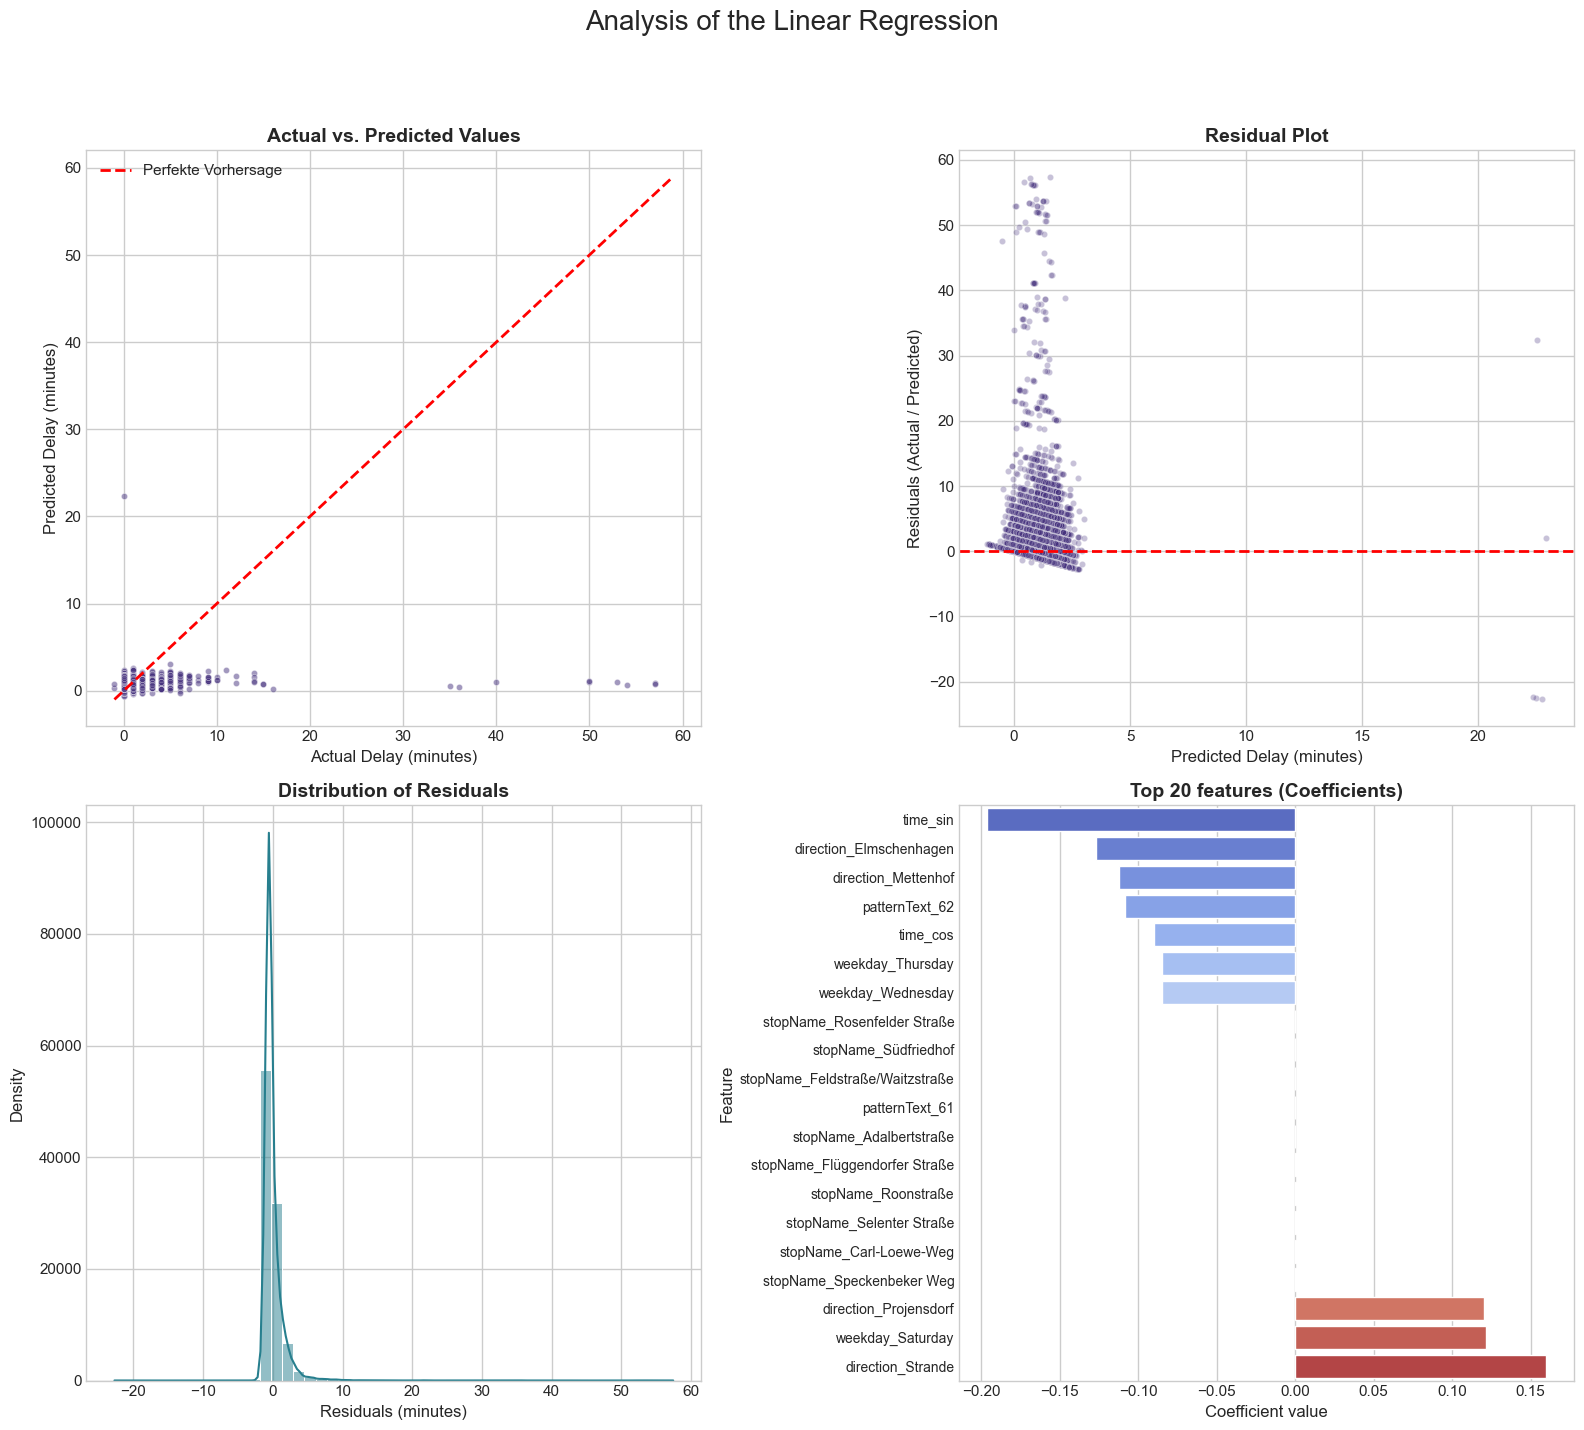

In [18]:
import seaborn as sns

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle("Analysis of the Linear Regression", fontsize=20, y=1.02)

# actual vs precited values
sample_indices = np.random.choice(X_test.index, size=min(5000, len(X_test)), replace=False)
y_test_sample = y_test.loc[sample_indices]
y_pred_sample = pandas.Series(y_pred, index=y_test.index).loc[sample_indices]

axes[0, 0].scatter(y_test_sample, y_pred_sample, alpha=0.5, s=20, edgecolors='w', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfekte Vorhersage')
axes[0, 0].set_xlabel("Actual Delay (minutes)", fontsize=12)
axes[0, 0].set_ylabel("Predicted Delay (minutes)", fontsize=12)
axes[0, 0].set_title("Actual vs. Predicted Values", fontsize=14, weight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True)

# residuals plot
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.3, s=20, edgecolors='w', linewidth=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel("Predicted Delay (minutes)", fontsize=12)
axes[0, 1].set_ylabel("Residuals (Actual / Predicted)", fontsize=12)
axes[0, 1].set_title("Residual Plot", fontsize=14, weight='bold')
axes[0, 1].grid(True)

sns.histplot(residuals, kde=True, ax=axes[1, 0], bins=50, color=sns.color_palette("viridis")[2])
axes[1, 0].set_xlabel("Residuals (minutes)", fontsize=12)
axes[1, 0].set_ylabel("Density", fontsize=12)
axes[1, 0].set_title("Distribution of Residuals", fontsize=14, weight='bold')
axes[1, 0].grid(True)

# top 20 coefficients
top_coeffs = pandas.concat([coeffs.head(10), coeffs.tail(10)])
top_coeffs_sorted = top_coeffs.sort_values()

sns.barplot(x=top_coeffs_sorted.values, y=top_coeffs_sorted.index, ax=axes[1, 1], palette="coolwarm")
axes[1, 1].set_xlabel("Coefficient value", fontsize=12)
axes[1, 1].set_ylabel("Feature", fontsize=12)
axes[1, 1].set_title("Top 20 features (Coefficients)", fontsize=14, weight='bold')
axes[1, 1].tick_params(axis='y', labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()